<a href="https://colab.research.google.com/github/anish-neervannan/ese546_final_project/blob/main/ese546_finalproj_stock_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ESE 546 Final Project: The Effect of Genetic Algorithms on Long Short Term Memory Networks with Attention Modules**

### **Authors**
- Anish Neervannan (PennKey: anishrn)
- Vinay Senthil (PennKey: vinayksk)
- Bhaskar Abhiraman (PennKey: bhaskara)

### **Import Kaggle Dataset**

1. Use Chrome Extension "[Get cookies.txt](https://chrome.google.com/webstore/detail/get-cookiestxt/bgaddhkoddajcdgocldbbfleckgcbcid?utm_campaign=en&utm_source=en-ha-na-us-bk-ext&utm_medium=ha)" to download cookies from [here](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) after logging in.
2. Save the file as "cookies.txt" and upload it in the next cell.
3. A version of "cookies.txt" is also in the shared Drive for this project.

In [5]:
from google.colab import files

uploaded = files.upload()

Saving cookies.txt to cookies.txt


This cell imports all the data (492 MB) straight from Kaggle to the Colab workspace.

In [6]:
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/download" -O data.zip
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Stocks/ergf.us.txt      
  inflating: Stocks/erh.us.txt       
  inflating: Stocks/eri.us.txt       
  inflating: Stocks/eric.us.txt      
  inflating: Stocks/erie.us.txt      
  inflating: Stocks/erii.us.txt      
  inflating: Stocks/erj.us.txt       
  inflating: Stocks/erm.us.txt       
  inflating: Stocks/ern.us.txt       
  inflating: Stocks/eros.us.txt      
  inflating: Stocks/eryp.us.txt      
  inflating: Stocks/es.us.txt        
  inflating: Stocks/esba.us.txt      
  inflating: Stocks/esbk.us.txt      
  inflating: Stocks/esca.us.txt      
  inflating: Stocks/esdi.us.txt      
  inflating: Stocks/esdiw.us.txt     
  inflating: Stocks/ese.us.txt       
  inflating: Stocks/esea.us.txt      
  inflating: Stocks/eses.us.txt      
  inflating: Stocks/esg.us.txt       
  inflating: Stocks/esgd.us.txt      
  inflating: Stocks/esge.us.txt      
  inflating: Stocks/esgf.us.txt      
  inflating: Stocks/esgg.us.txt      

For example, graph AAPL over time.

         Date     Open     High      Low    Close    Volume  OpenInt
0  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0
1  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0
2  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0
3  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0
4  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0


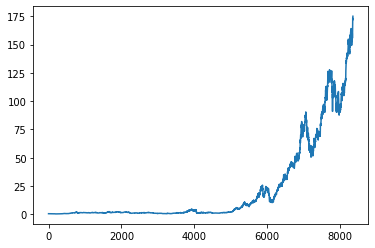

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

aapl_data = pd.read_csv("Stocks/aapl.us.txt")
print(aapl_data.head())
plt.plot(aapl_data.Open)

### **LSTM for Numerical Sequences**

### To do:


*   Plagiarize less - everything is mostly changed except: (1) get_batch to process multiple batches, (2) change LSTM() network architecture (maybe use the one from earlier homework), (3) change eval code, (4) why is test_data not scaled?
*   Validation metrics (MAE per sector)
*   Preprocess all stock data by sector/S&P
*   Implement mini-batching (looking at fixed-length sequences of various stocks)
*   Characterize base LSTM
*   Attention
*   Get S&P 500 info/sector info/stock symbols

LSTM for Numerical Sequences based on:
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/


In [19]:
# from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# Preprocess the data, select the appropriate stocks and convert to numpy
# Rescale training data between -1 and 1
stock = 'aapl'
stock_pd_frame = pd.read_csv("Stocks/{}.us.txt".format(stock))
stock_np = np.asarray(stock_pd_frame.Open)

train_size = 500
test_size = 12

train_data = stock_np[-train_size-test_size:-test_size]
test_data = stock_np[-test_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [21]:
# helper method to get a training sequence starting at a particular point in the sequence
def get_batch(input_data, seq_len, i):
    train_seq = input_data[i:i+seq_len]
    train_label = input_data[i+seq_len:i+seq_len+1]
    return (train_seq ,train_label)

In [24]:
# LSTM class module defined
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [34]:
epochs = 150
seq_len = 12
print_and_save_interval = 5
num_batches = len(train_data_normalized) - seq_len

model = LSTM().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

for epoch in range(epochs):
    for j in range(num_batches):
        # Fetch the batched data and push to GPU
        X, y = get_batch(train_data_normalized, seq_len, j)
        X = torch.Tensor(X).to(device)
        y = torch.Tensor(y).to(device)

        # Zero out the gradients and hidden cells
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        # Compute predicted value
        y_pred = model(X)

        # Compute loss and backpropagate
        loss = criterion(y_pred, torch.flatten(y))
        loss.backward()
        optimizer.step()

    # TODO: Save average losses more frequently and plot them
    if epoch % print_and_save_interval == 0:
        print ('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

print ('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
Epoch [1/150], Training Loss: 0.0326
Epoch [6/150], Training Loss: 0.0414
Epoch [11/150], Training Loss: 0.0175
Epoch [16/150], Training Loss: 0.0114
Epoch [21/150], Training Loss: 0.0072
Epoch [26/150], Training Loss: 0.0060
Epoch [31/150], Training Loss: 0.0068
Epoch [36/150], Training Loss: 0.0038
Epoch [41/150], Training Loss: 0.0070
Epoch [46/150], Training Loss: 0.0168
Epoch [51/150], Training Loss: 0.0181
Epoch [56/150], Training Loss: 0.0113
Epoch [61/150], Training Loss: 0.0056
Epoch [66/150], Training Loss: 0.0325
Epoch [71/150], Training Loss: 0.0324
Epoch [76/150], Training Loss: 0.0403
Epoch [81/150], Training Loss: 0.0519
Epoch [86/150], Training Loss: 0.0606
Epoch [91/150], Training Loss: 0.0589
Epoch [96/150], Training Loss: 0.0351
Epoch [101/150], Training Loss: 0.0064
Epoch [106/150], Training Loss: 0.0230
Epoch [111/150], Training Loss: 0.0229
Epoch [116/150], Training Loss:

In [35]:
num_preds = 12

test_inputs = np.ndarray.flatten(train_data_normalized[-seq_len:]).tolist()

model.eval()

for i in range(num_preds):
    seq = torch.FloatTensor(test_inputs[-seq_len:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

In [36]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[seq_len:] ).reshape(-1, 1))


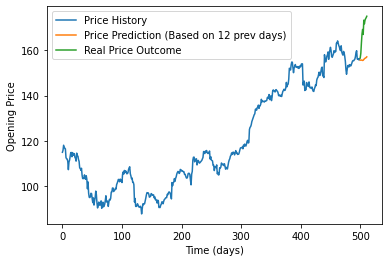

In [37]:
ts = np.arange(0,train_data_size + test_data_size,1)
plt.plot(ts[:train_data_size],train_data)
plt.plot(ts[-test_data_size:],actual_predictions)
plt.plot(ts[-test_data_size:],stock_opens[-test_data_size:])
plt.xlabel('Time (days)')
plt.ylabel('Opening Price')
plt.legend(['Price History', 'Price Prediction (Based on 12 prev days)','Real Price Outcome'])